In [1]:
#imports
!pip install numpy astropy matplotlib scipy sunpy[all]
!pip install sunkit-image
!pip install aiapy
from astropy import units as u
from astropy.coordinates import SkyCoord
import sunpy.map
from sunpy.map import Map
from sunpy.net.jsoc import JSOCClient, attrs as jsoc
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, AsinhStretch
from sunpy.visualization.colormaps import cm
from matplotlib.patches import Rectangle
from reproject import reproject_interp
import matplotlib
from IPython.display import HTML
from sunkit_image import trace
from aiapy.calibrate import register, update_pointing
from aiapy.calibrate.util import get_pointing_table
from matplotlib.patches import Polygon
from glob import glob
from scipy.interpolate import CubicSpline
import matplotlib.animation as animation
import matplotlib.patches as patches

# JSOC Client
JSOC = JSOCClient()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.2/962.2 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.3/350.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.2/195.2 kB 11

In [13]:
JSOC = JSOCClient()

# Define the time window and wavelength set
time_str = "2010-12-11T09:30:00"
wavelengths = [1700, 171, 94, 304, 1600, 193] * u.angstrom

maps = []

from astropy.time import Time, TimeDelta

initial_time = Time(time_str)

for wl in wavelengths:
    series = "aia.lev1_uv_24s" if wl.value in [1600, 1700] else "aia.lev1_euv_12s"
    # Define time window based on series
    if series == "aia.lev1_uv_24s":
        end_time = initial_time + TimeDelta(24 * u.second)
        time_window = jsoc.Time(initial_time, end_time)
    else:
        end_time = initial_time + TimeDelta(12 * u.second)
        time_window = jsoc.Time(initial_time, end_time)

    result = JSOC.search(
        time_window,
        jsoc.Series(series),
        jsoc.Wavelength(wl),
        jsoc.Segment("image"),
        jsoc.Notify("yadav23@iiserb.ac.in")
    )

    # Check if any file was returned
    if not result:
        print(f" No result for {wl}")
        continue

    files = JSOC.fetch(result)
    m = sunpy.map.Map(files[0])
    m = register(m)  # AIA correction
    maps.append(m)

# Unpack into individual variables just like Fido-based routine
aia_1700, aia_171, aia_94, aia_304, aia_1600, aia_193 = maps

INFO:sunpy:2 URLs found for download. Full request totaling 24MB


INFO: 2 URLs found for download. Full request totaling 24MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

INFO:sunpy:2 URLs found for download. Full request totaling 24MB


INFO: 2 URLs found for download. Full request totaling 24MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

INFO:sunpy:2 URLs found for download. Full request totaling 14MB


INFO: 2 URLs found for download. Full request totaling 14MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

INFO:sunpy:2 URLs found for download. Full request totaling 19MB


INFO: 2 URLs found for download. Full request totaling 19MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

INFO:sunpy:2 URLs found for download. Full request totaling 21MB


INFO: 2 URLs found for download. Full request totaling 21MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

INFO:sunpy:2 URLs found for download. Full request totaling 23MB


INFO: 2 URLs found for download. Full request totaling 23MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

INFO:sunpy:1 URLs found for download. Full request totaling 16MB


INFO: 1 URLs found for download. Full request totaling 16MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

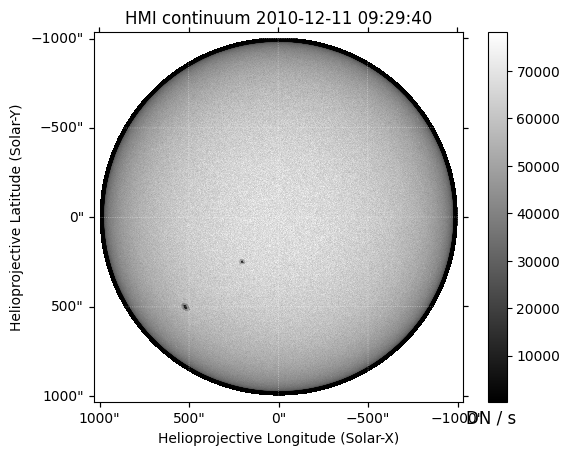

In [27]:
result_hmi = JSOC.search(
    jsoc.Time("2010-12-11T09:30:00", "2010-12-11T09:30:12"),
    jsoc.Series("hmi.Ic_45s"),
    jsoc.Segment("continuum"),
    jsoc.Notify("yadav23@iiserb.ac.in")
)

if result_hmi:
    downloaded_hmi = JSOC.fetch(result_hmi)
    hmi_map = Map(downloaded_hmi[0])
    hmi_map.peek()
else:
    print(" No HMI result found.")


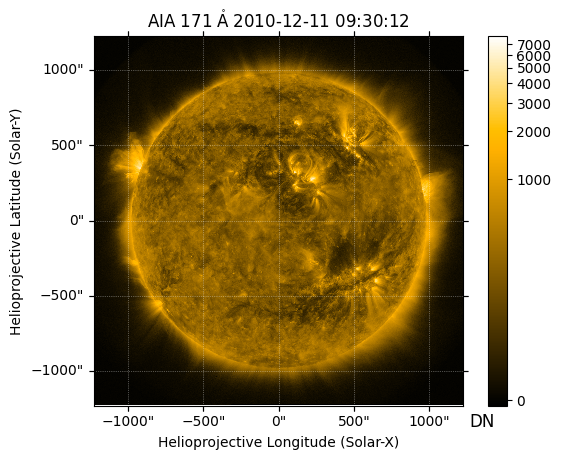

In [59]:
from sunpy.visualization import wcsaxes_compat
aia_171.peek()



In [98]:
bottom_left = SkyCoord(180 * u.arcsec, 220 * u.arcsec, frame=aia_171.coordinate_frame)
top_right   = SkyCoord(238 * u.arcsec, 280 * u.arcsec, frame=aia_171.coordinate_frame)



INFO:sunpy:Using image-based autoalignment
INFO:sunpy:Using image-based autoalignment


INFO: Using image-based autoalignment [sunpy.map.mapbase]
INFO: Using image-based autoalignment [sunpy.map.mapbase]


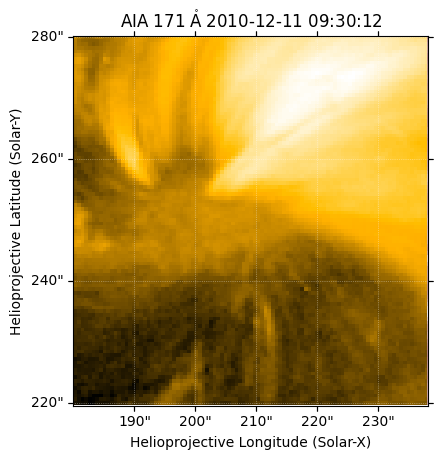

In [99]:
aia1700_sub = aia_1700.submap(bottom_left=bottom_left, top_right=top_right)
aia1700_sub.plot()

aia304_sub = aia_304.submap(bottom_left=bottom_left, top_right=top_right)
aia304_sub.plot()

aia171_sub = aia_171.submap(bottom_left=bottom_left, top_right=top_right)
aia171_sub.plot()

In [100]:
aia1700_sub = aia_1700.submap(bottom_left=bottom_left, top_right=top_right)
aia171_sub  = aia_171.submap(bottom_left=bottom_left, top_right=top_right)
aia94_sub   = aia_94.submap(bottom_left=bottom_left, top_right=top_right)
aia304_sub  = aia_304.submap(bottom_left=bottom_left, top_right=top_right)
aia1600_sub = aia_1600.submap(bottom_left=bottom_left, top_right=top_right)
aia193_sub  = aia_193.submap(bottom_left=bottom_left, top_right=top_right)

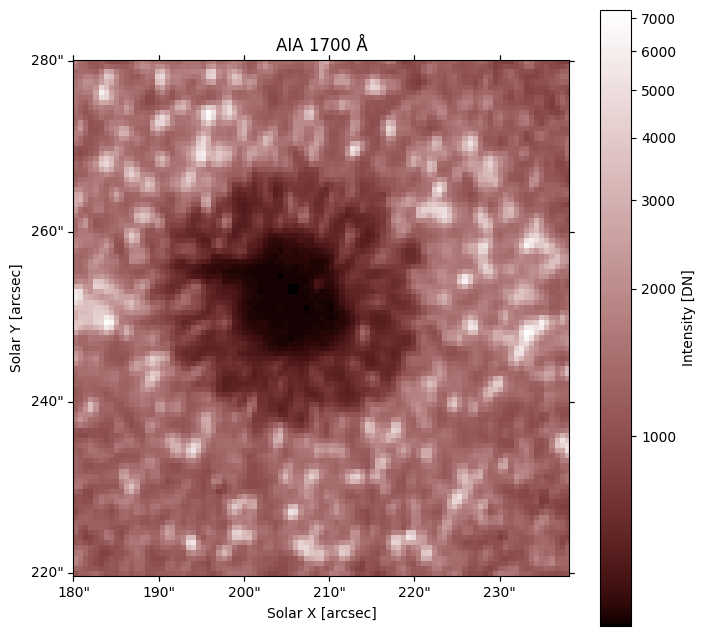

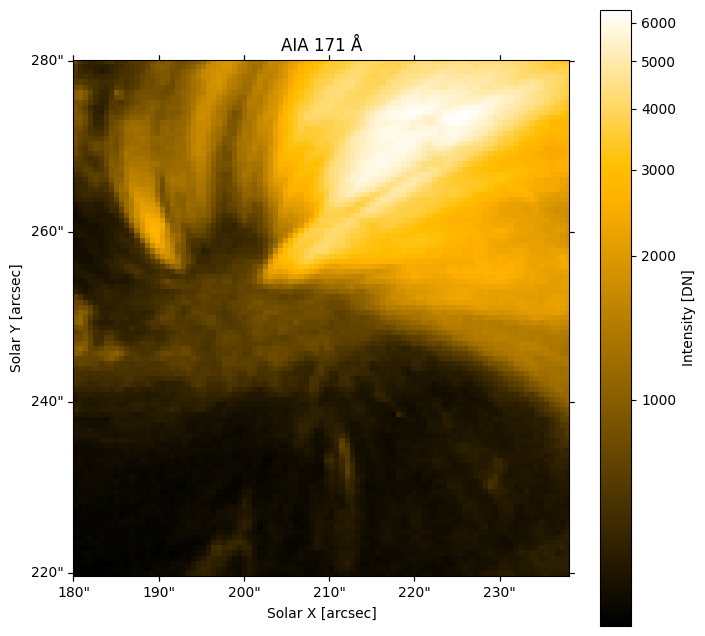

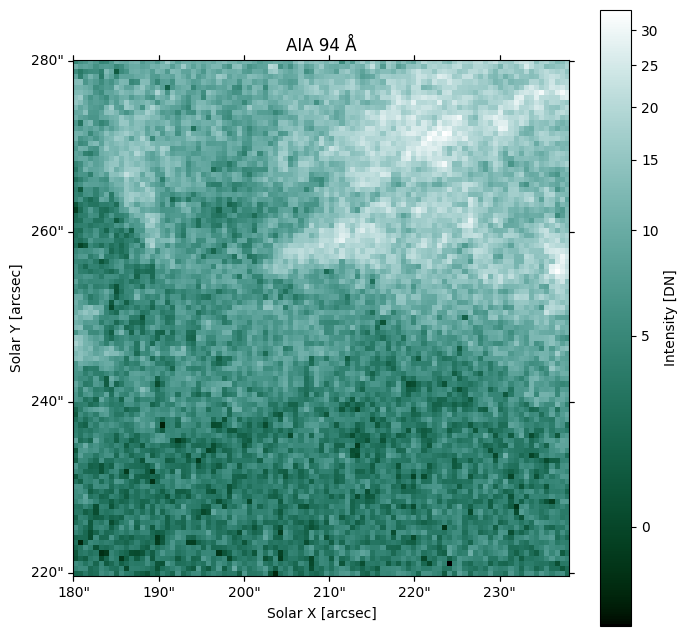

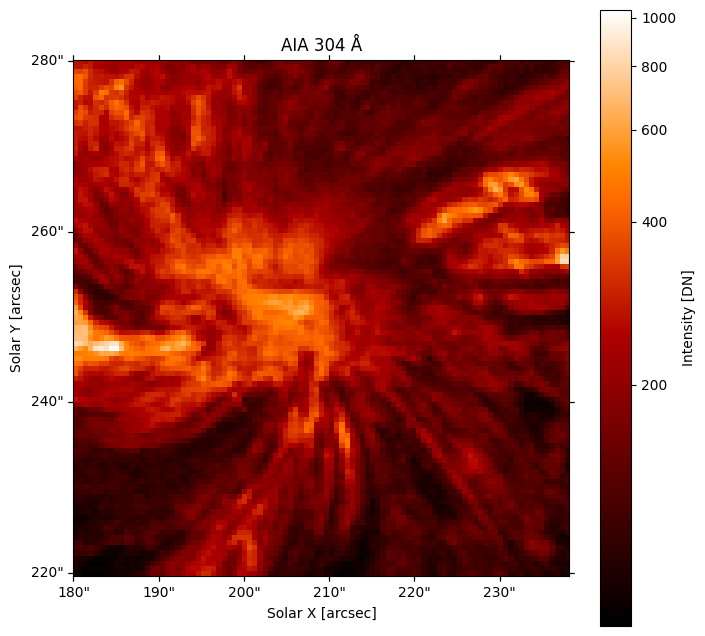

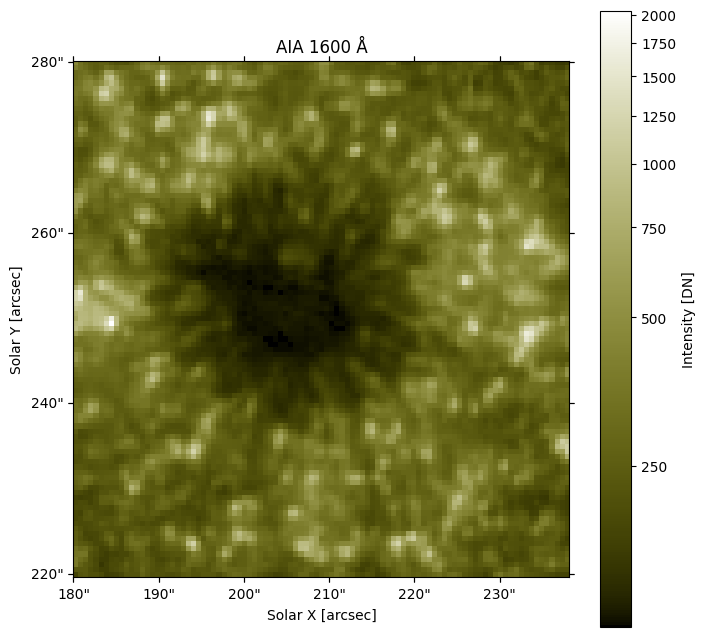

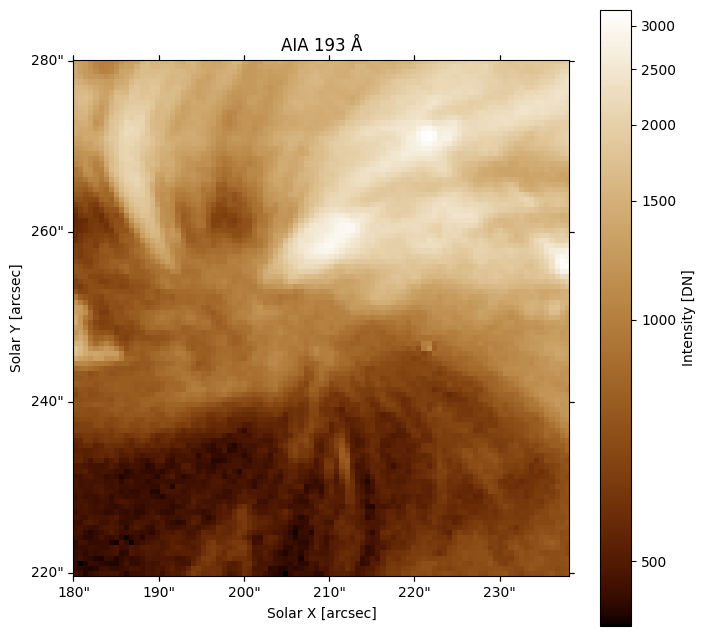

In [104]:
from matplotlib import pyplot as plt
from astropy.visualization import ImageNormalize, AsinhStretch

import sunpy.visualization.colormaps as sunpy_cm

cmap_dict = {
    "1700 Å": sunpy_cm.cmlist['sdoaia1700'],
    "1600 Å": sunpy_cm.cmlist['sdoaia1600'],
    "171 Å":  sunpy_cm.cmlist['sdoaia171'],
    "193 Å":  sunpy_cm.cmlist['sdoaia193'],
    "94 Å":   sunpy_cm.cmlist['sdoaia94'],
    "304 Å":  sunpy_cm.cmlist['sdoaia304']
}



submaps = {
    "1700 Å": aia1700_sub,
    "171 Å": aia171_sub,
    "94 Å": aia94_sub,
    "304 Å": aia304_sub,
    "1600 Å": aia1600_sub,
    "193 Å": aia193_sub
}


# Plot submaps without contours
for title, smap in submaps.items():
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection=smap.wcs)

    # Normalize and plot image
    norm = ImageNormalize(stretch=AsinhStretch())
    im = ax.imshow(smap.data, cmap=cmap_dict.get(title, 'gray'), origin='lower', norm=norm)

    ax.set_xlabel('Solar X [arcsec]')
    ax.set_ylabel('Solar Y [arcsec]')
    ax.set_title(f'AIA {title}')

    # Colorbar
    plt.colorbar(im, ax=ax, label=f'Intensity [{smap.unit}]')

    plt.savefig(f"AIA_{title.replace(' ', '').replace('Å', '')}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [105]:
# Load and register HMI continuum map
hmi_ic = Map(JSOC.fetch(JSOC.search(
    jsoc.Time("2010-12-11T09:30:00", "2010-12-11T09:30:01"),
    jsoc.Series("hmi.Ic_45s"),
    jsoc.Segment("continuum"),
    jsoc.Notify("yadav23@iiserb.ac.in")
))[0])

hmi_ic = register(hmi_ic)
hmi_ic_sub = hmi_ic.submap(bottom_left=bottom_left, top_right=top_right)

# Reproject HMI submap to match AIA WCS
reference_aia = aia171_sub
hmi_reproj_data, _ = reproject_interp((hmi_ic_sub.data, hmi_ic_sub.wcs),
                                      reference_aia.wcs,
                                      shape_out=reference_aia.data.shape)

# Umbra contour threshold
umbra_threshold = 22000


INFO:sunpy:1 URLs found for download. Full request totaling 16MB


INFO: 1 URLs found for download. Full request totaling 16MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

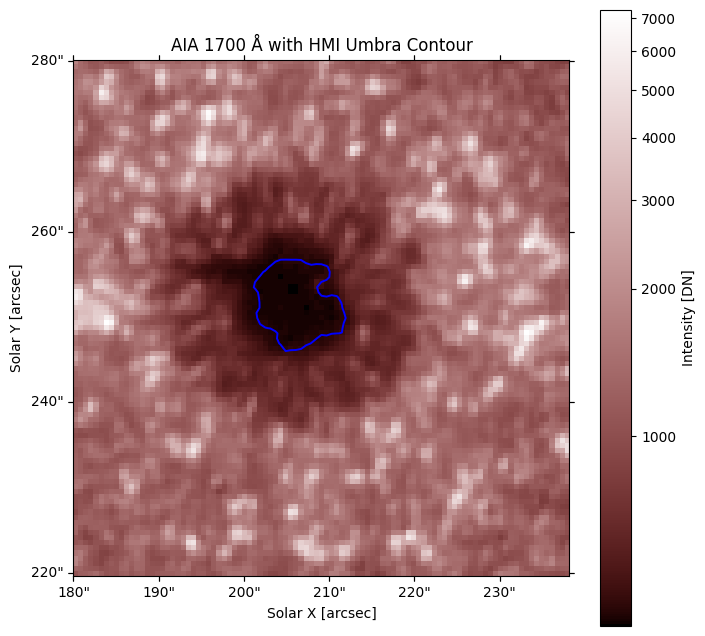

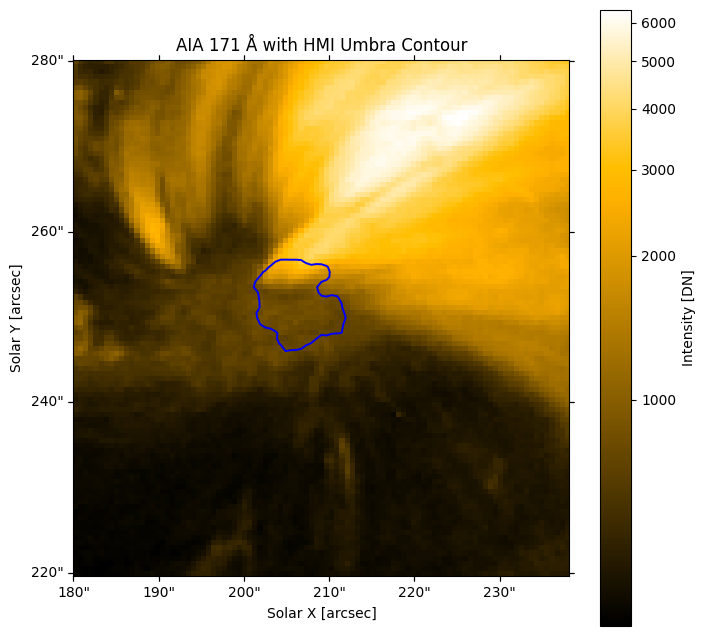

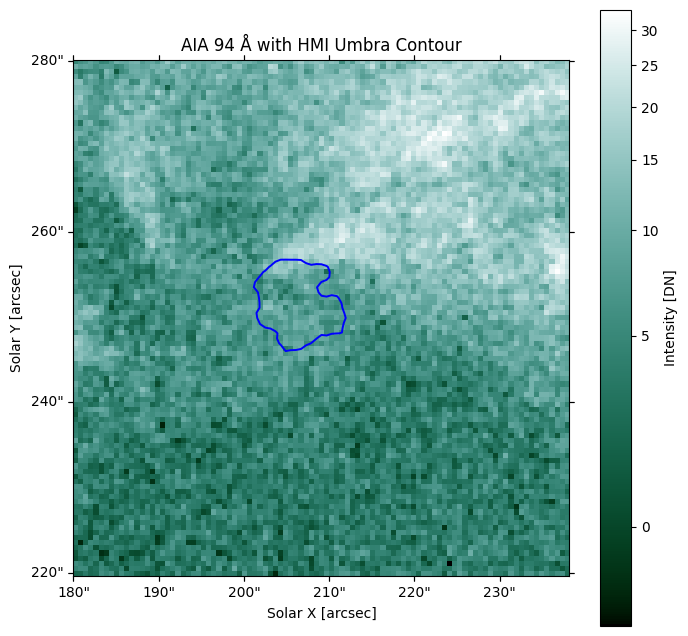

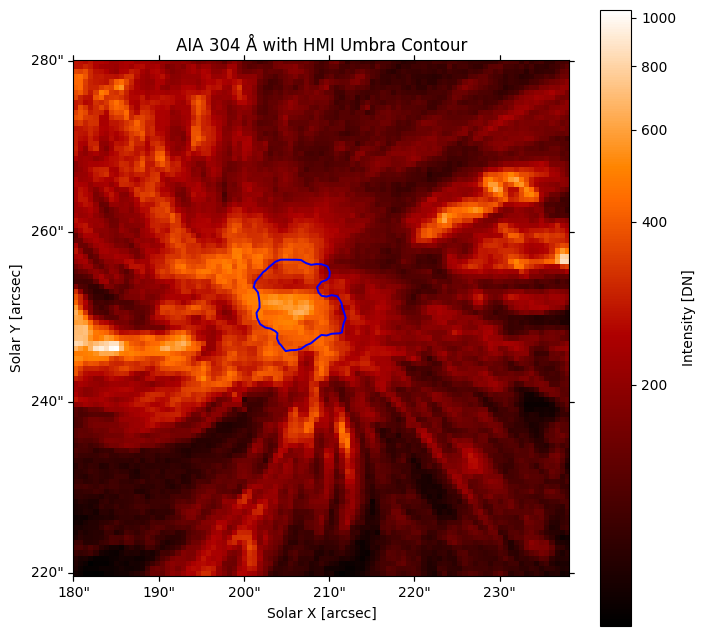

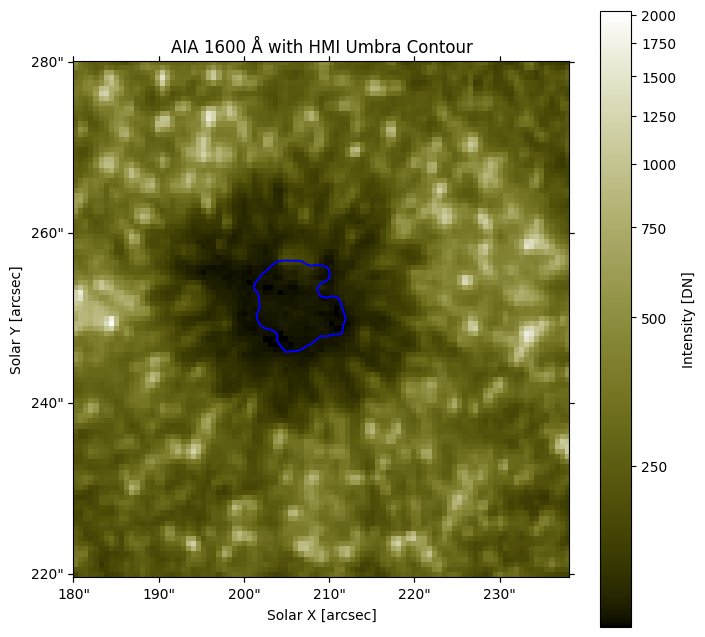

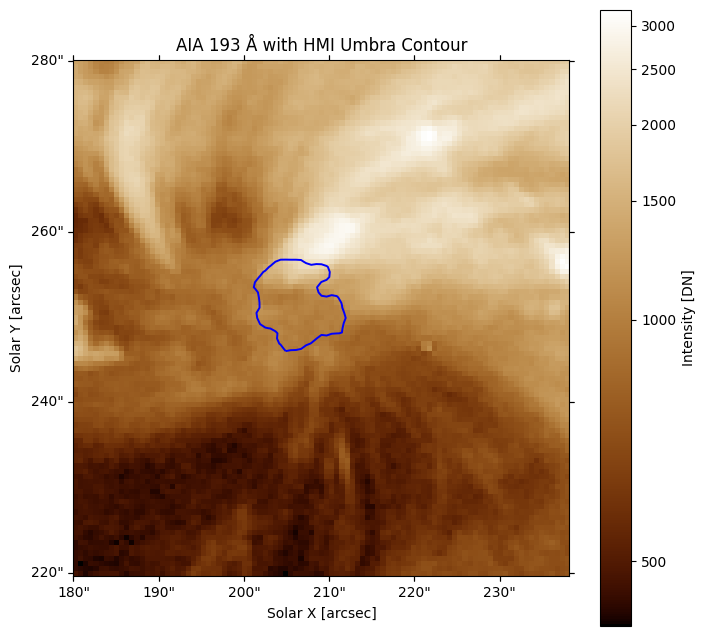

In [112]:
!pip install reproject
from reproject import reproject_interp

from astropy.visualization import ImageNormalize, AsinhStretch
from matplotlib import pyplot as plt
import sunpy.visualization.colormaps as sunpy_cm
from reproject import reproject_interp # Import reproject_interp


# Use the cmlist dictionary to access SunPy AIA colormaps
cmap_dict = {
    "1700 Å": sunpy_cm.cmlist['sdoaia1700'],
    "1600 Å": sunpy_cm.cmlist['sdoaia1600'],
    "171 Å":  sunpy_cm.cmlist['sdoaia171'],
    "193 Å":  sunpy_cm.cmlist['sdoaia193'],
    "94 Å":   sunpy_cm.cmlist['sdoaia94'],
    "304 Å":  sunpy_cm.cmlist['sdoaia304']
}

# Define the submaps dictionary (assuming these variables are defined elsewhere)
submaps = {
    "1700 Å": aia1700_sub,
    "171 Å": aia171_sub,
    "94 Å": aia94_sub,
    "304 Å": aia304_sub,
    "1600 Å": aia1600_sub,
    "193 Å": aia193_sub
}


for title, smap in submaps.items():
    # Dynamically reproject HMI to this AIA map's WCS
    hmi_reproj_data, _ = reproject_interp((hmi_ic_sub.data, hmi_ic_sub.wcs),
                                          smap.wcs,
                                          shape_out=smap.data.shape)

    # Plot
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection=smap.wcs)

    norm = ImageNormalize(stretch=AsinhStretch())
    im = ax.imshow(smap.data, cmap=cmap_dict.get(title, 'gray'), origin='lower', norm=norm)

    ax.contour(hmi_reproj_data, levels=[umbra_threshold], colors='blue', linewidths=1.4)

    ax.set_xlabel('Solar X [arcsec]')
    ax.set_ylabel('Solar Y [arcsec]')
    ax.set_title(f"AIA {title} with HMI Umbra Contour")
    plt.colorbar(im, ax=ax, label=f"Intensity [{smap.unit}]")

    plt.savefig(f"AIA_{title.replace(' ', '').replace('Å', '')}_umbra_aligned.png", dpi=300, bbox_inches='tight')
    plt.show()

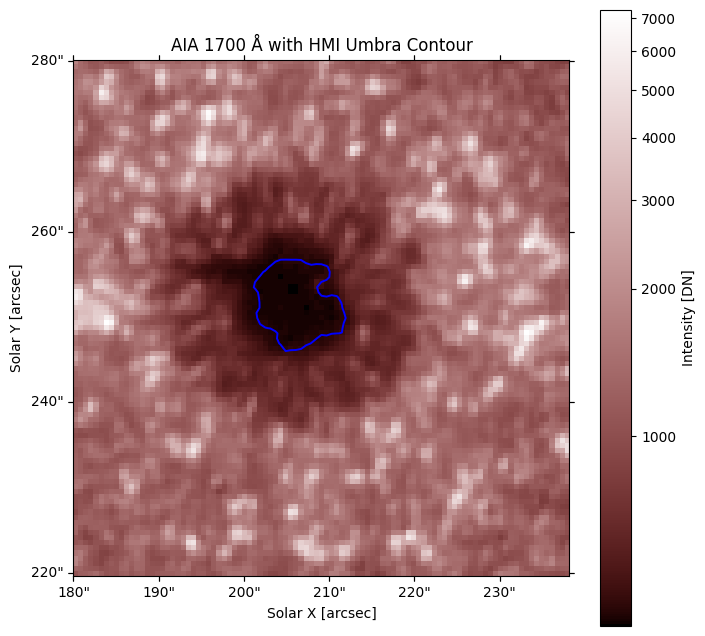

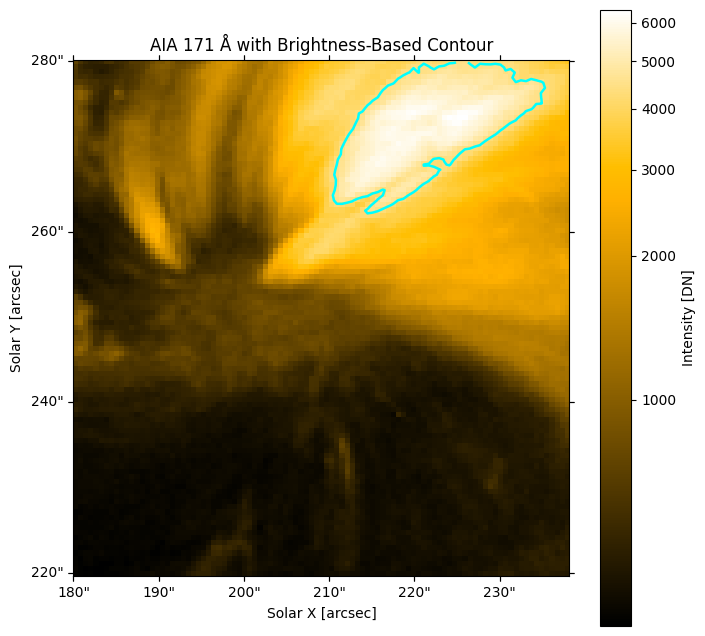

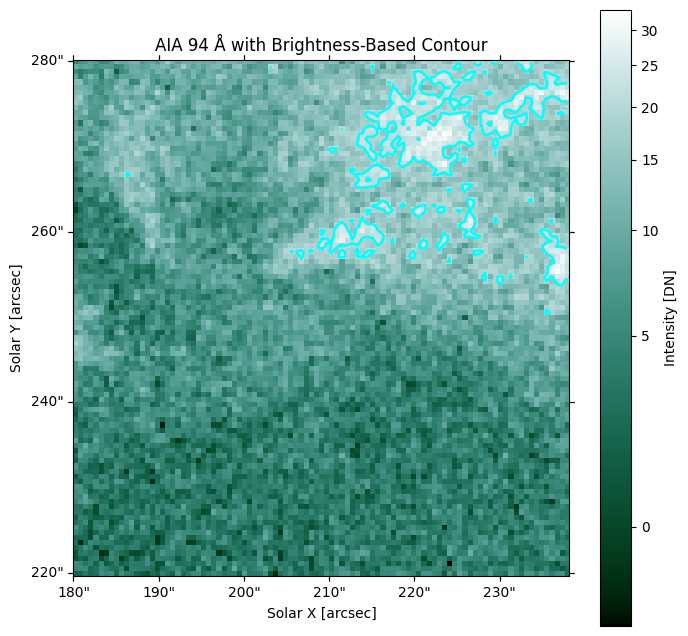

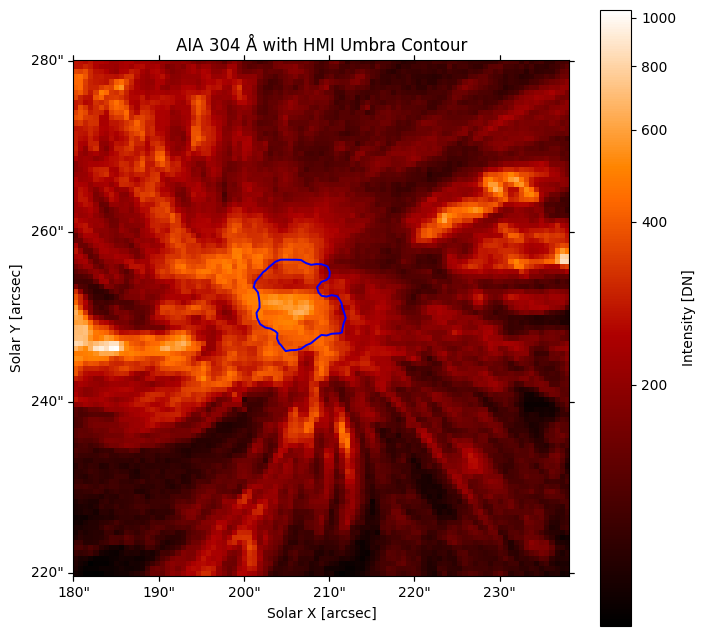

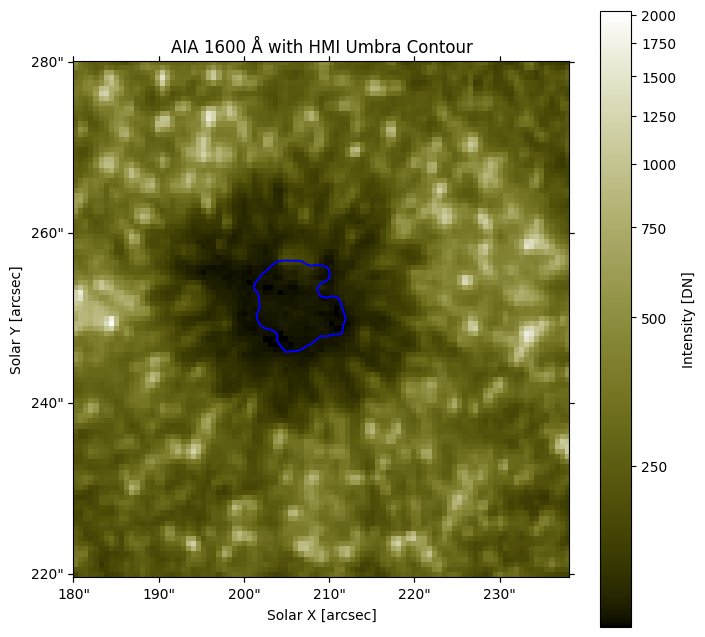

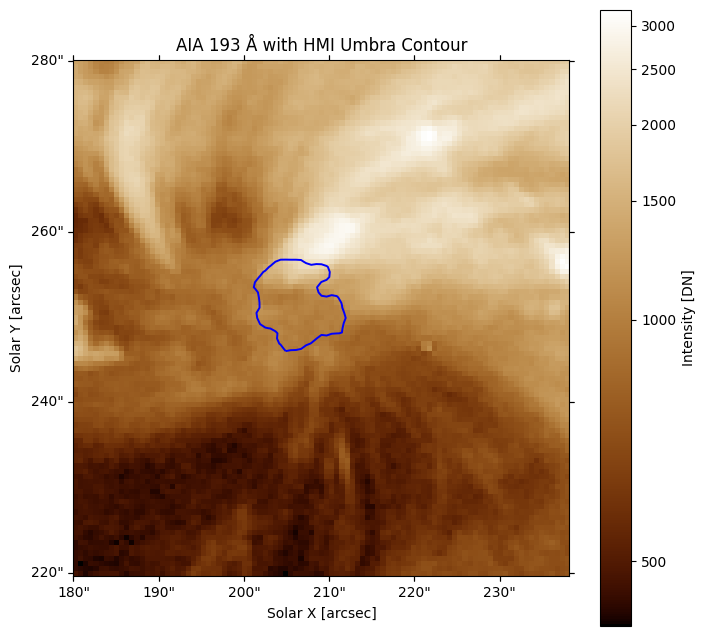

In [118]:
for title, smap in submaps.items():
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection=smap.wcs)

    # Show AIA image
    norm = ImageNormalize(stretch=AsinhStretch())
    im = ax.imshow(smap.data, cmap=cmap_dict.get(title, 'gray'), origin='lower', norm=norm)

    if title in ["171 Å", "94 Å","193"]:
        # Contour from AIA brightness
        threshold = smap.data.mean() + 2.0 * smap.data.std()
        ax.contour(smap.data, levels=[threshold], colors='cyan', linewidths=1.8)
    else:
        # Contour from reprojected HMI
        hmi_reproj_data, _ = reproject_interp((hmi_ic_sub.data, hmi_ic_sub.wcs),
                                              smap.wcs,
                                              shape_out=smap.data.shape)
        ax.contour(hmi_reproj_data, levels=[umbra_threshold], colors='blue', linewidths=1.4)

    # Labeling
    ax.set_xlabel('Solar X [arcsec]')
    ax.set_ylabel('Solar Y [arcsec]')
    ax.set_title(f'AIA {title} with Brightness-Based Contour' if title in ["171 Å", "94 Å"] else f'AIA {title} with HMI Umbra Contour')
    plt.colorbar(im, ax=ax, label=f'Intensity [{smap.unit}]')

    plt.savefig(f"AIA_{title.replace(' ', '').replace('Å', '')}_contour.png", dpi=300, bbox_inches='tight')
    plt.show()


